In [80]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from pathlib import Path
import pandas as pd

In [113]:
path = Path.home().joinpath("diaz_rincon/VTA_SNc")
folder_path = "deconvoluted"

In [114]:
traces_path = list(Path(path).joinpath(folder_path).iterdir())
traces_path

[PosixPath('/home/ic3/diaz_rincon/VTA_SNc/deconvoluted/gc_ephys016_03_04_vta_injected_deconv.npy'),
 PosixPath('/home/ic3/diaz_rincon/VTA_SNc/deconvoluted/gc_ephys029_03_07_snc_control_deconv.npy'),
 PosixPath('/home/ic3/diaz_rincon/VTA_SNc/deconvoluted/gc_ephys017_03_04_snc_injected_deconv.npy'),
 PosixPath('/home/ic3/diaz_rincon/VTA_SNc/deconvoluted/gc_ephys018_03_04_snc_injected_deconv.npy'),
 PosixPath('/home/ic3/diaz_rincon/VTA_SNc/deconvoluted/gc_ephys030_03_07_snc_injected_deconv.npy'),
 PosixPath('/home/ic3/diaz_rincon/VTA_SNc/deconvoluted/gc_ephys005_03_02_snc_injected_deconv.npy'),
 PosixPath('/home/ic3/diaz_rincon/VTA_SNc/deconvoluted/gc_ephys018_03_05_snc_control_deconv.npy'),
 PosixPath('/home/ic3/diaz_rincon/VTA_SNc/deconvoluted/gc_ephys003_03_02_vta_control_deconv.npy'),
 PosixPath('/home/ic3/diaz_rincon/VTA_SNc/deconvoluted/gc_ephys006_03_05_snc_injected_deconv.npy'),
 PosixPath('/home/ic3/diaz_rincon/VTA_SNc/deconvoluted/gc_ephys021_03_06_vta_control_deconv.npy'),
 Pos

Creating traces dictionary

In [115]:
traces = {}
for iter, file_name in enumerate(traces_path):
    traces[iter] = np.load(file_name, allow_pickle=True)    

Each key corresponds to a video

In [116]:
traces.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

Every video has a different number of cells and number of frames

In [117]:
for i in range(len(traces)):
    print(traces[i].shape)

(10, 750)
(13, 2250)
(21, 2250)
(21, 2250)
(34, 2250)
(28, 2250)
(37, 2250)
(27, 2250)
(20, 2250)
(49, 2250)
(19, 1019)
(42, 2250)
(31, 2250)
(67, 2250)
(10, 750)
(23, 2250)
(27, 2250)
(37, 2764)
(28, 2250)
(49, 2250)
(31, 2250)
(27, 2250)
(39, 2250)
(55, 2250)
(38, 2250)
(34, 2250)
(51, 2250)
(25, 2250)
(16, 2249)
(43, 2250)
(32, 2250)
(28, 2250)
(17, 3000)
(24, 2250)


Creating groups (vta_injected, snc_injected, vta_control, snc_control)

In [118]:
vta_injected = []
snc_injected = []
vta_control = []
snc_control = []

for iter, file_name in enumerate(traces_path):
    if folder_path == "traces":
        if "vta_injected" in str(file_name):
            vta_injected.append(iter)
        if "snc_injected" in str(file_name):
            snc_injected.append(iter)
        if "vta_control" in str(file_name):
            vta_control.append(iter)
        if "snc_control" in str(file_name):
            snc_control.append(iter)
    else:
        if "vta_injected_deconv" in str(file_name):
            vta_injected.append(iter)
        if "snc_injected_deconv" in str(file_name):
            snc_injected.append(iter)
        if "vta_control_deconv" in str(file_name):
            vta_control.append(iter)
        if "snc_control_deconv" in str(file_name):
            snc_control.append(iter)

Control groups

In [119]:
vta_injected, vta_control

([0, 18, 20, 21, 22, 27], [7, 9, 11, 12])

Injected groups

In [120]:
snc_control, snc_injected

([1, 6, 10, 19, 24, 25, 30, 33],
 [2, 3, 4, 5, 8, 13, 14, 15, 16, 17, 23, 26, 28, 29, 31, 32])

Some numbers

In [121]:
print(f"There are:")
print(f"{len(vta_control)} videos with normal quantities of αS in VTA")
print(f"{len(vta_injected)} videos with over expression of αS in VTA")
print(f"{len(snc_control)} videos with normal quantities of αS in SNc")
print(f"{len(snc_injected)} videos with over expression of αS in SNc")

There are:
4 videos with normal quantities of αS in VTA
6 videos with over expression of αS in VTA
8 videos with normal quantities of αS in SNc
16 videos with over expression of αS in SNc


## Plotting Cells

In [122]:
# for i in range(len(traces)):
#     frames_per_second = 25
#     num_cells = traces[i].shape[0]
#     samples = traces[i].shape[1]
#     duration = samples / frames_per_second
#     time = np.arange(start = 0, stop=int(duration), step=1/frames_per_second)
    
#     # Plot the traces
#     fig, axs = plt.subplots(num_cells, figsize=(20, 40))
#     for cell_num in range(num_cells):
#         axs[cell_num].autoscale(enable=None, axis="x", tight=True)
#         # axs[cell_num].set_ylabel(f"ROI {cell_num}", rotation=0)
#         axs[cell_num].title.set_text(f'ROI {cell_num + 1}')
#         # axs[cell_num].set_xlabel("Time")
#         axs[cell_num].plot(time,traces[i][cell_num, 0:len(time)])

Calculating Spearman's Rho between all activity of cells per video and extracting p-value for each correlation

In [123]:
corrs = {}
pvals = {}
# Correlation coefficients
for i in range(len(traces)):
    corrs[i], pvals[i] = stats.spearmanr(np.transpose(traces[i]))

In [124]:
corrs.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [125]:
corrs[2]

array([[ 1.00000000e+00, -2.22887965e-02,  1.93455277e-02,
         3.93913240e-02, -2.12294019e-03,  2.01075909e-02,
         1.82203130e-02,  3.27463690e-02, -1.09910160e-02,
         8.14256427e-03,  2.97956951e-02, -5.00018494e-02,
         5.39983077e-02,  3.77069948e-02,  4.73690821e-02,
        -1.19951274e-02, -1.11024687e-02,  3.51067264e-03,
        -1.63178895e-02, -3.73300642e-02, -4.58347677e-02],
       [-2.22887965e-02,  1.00000000e+00,  2.02799671e-03,
        -1.06113887e-02,  1.66489977e-04,  5.56827628e-02,
        -1.32234691e-02,  1.21891806e-02,  1.25647101e-02,
        -1.23879583e-02,  1.73062475e-02, -3.85408889e-02,
         3.76745733e-02, -3.42710444e-02,  6.91384462e-03,
        -6.56447508e-03,  3.39211913e-02,  2.29947893e-02,
        -1.69583051e-02,  5.20341440e-02, -6.97106529e-02],
       [ 1.93455277e-02,  2.02799671e-03,  1.00000000e+00,
         7.16933336e-02,  3.60593215e-02,  3.77487379e-02,
        -1.49315335e-02,  3.76627673e-02,  5.87096737e

Displaying the correlations (adjacency matrix)


/tmp/ipykernel_10527/1764771094.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig2 = plt.figure()


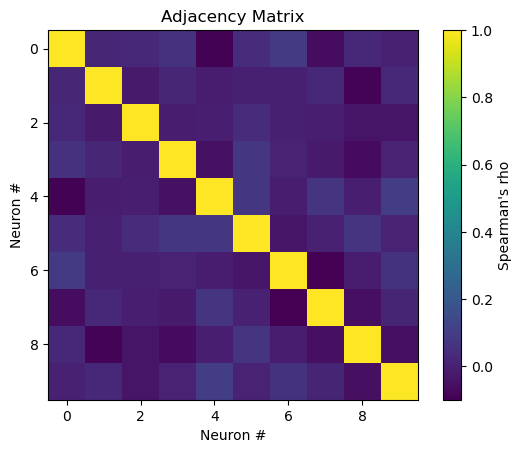

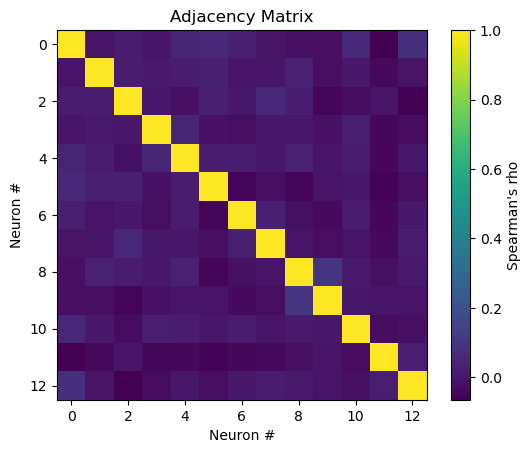

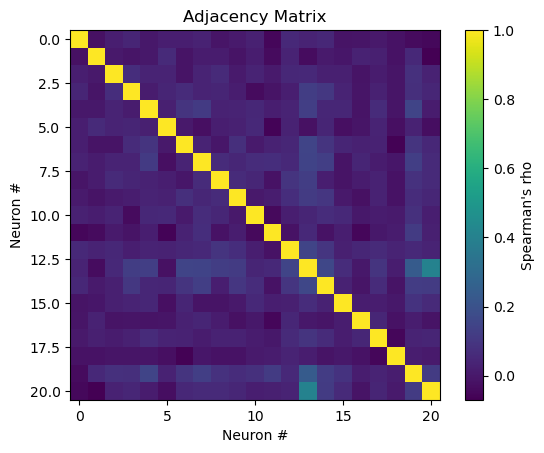

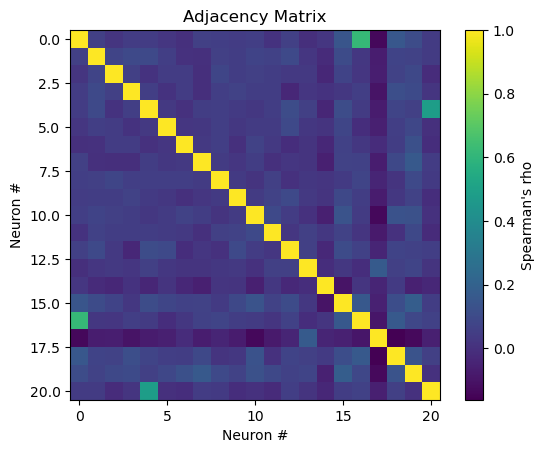

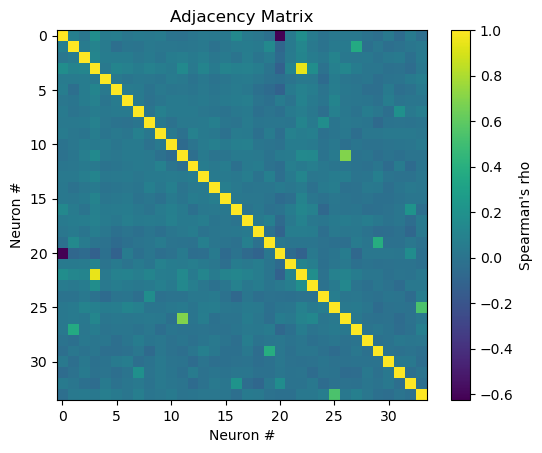

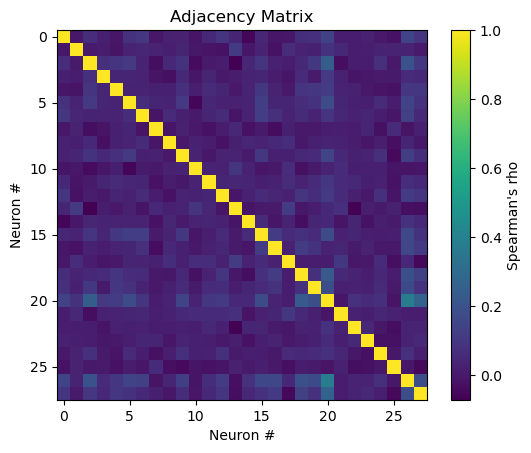

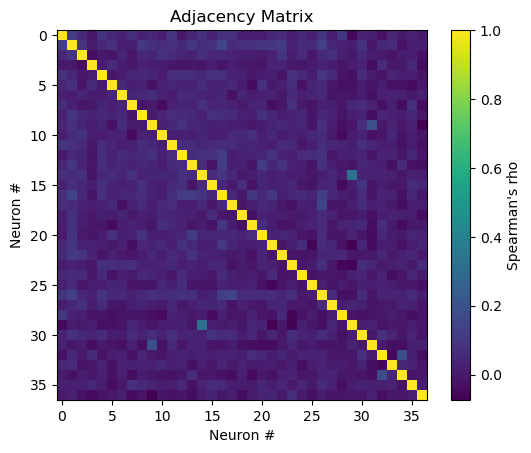

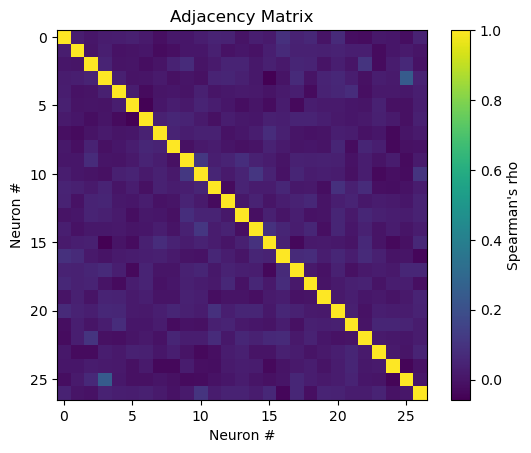

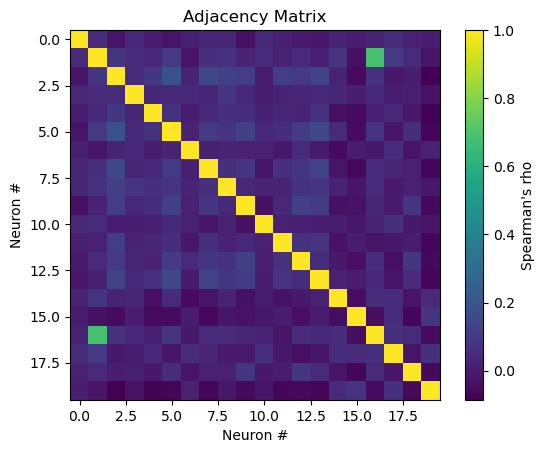

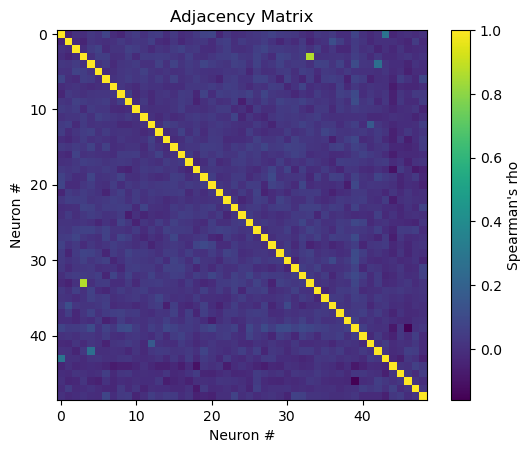

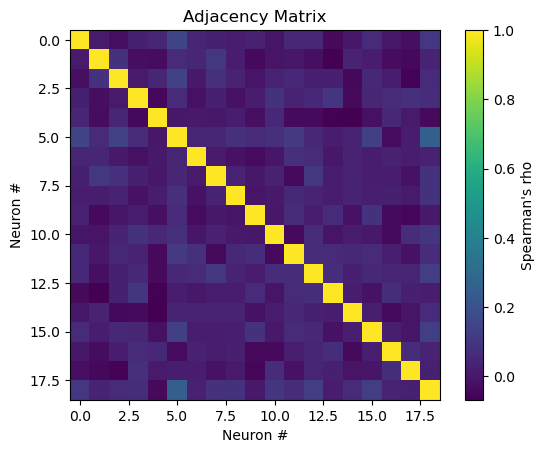

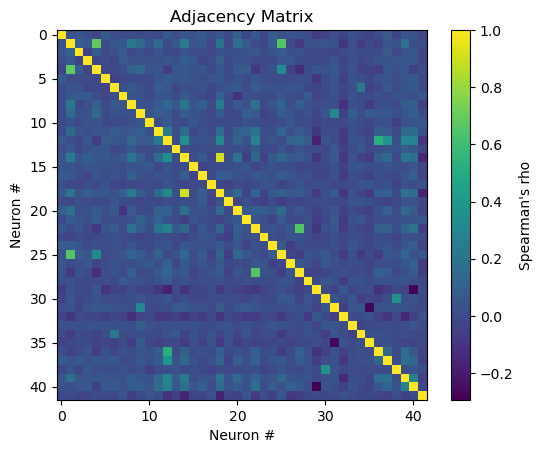

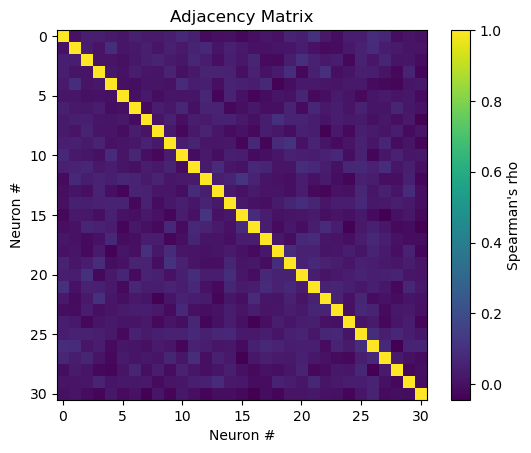

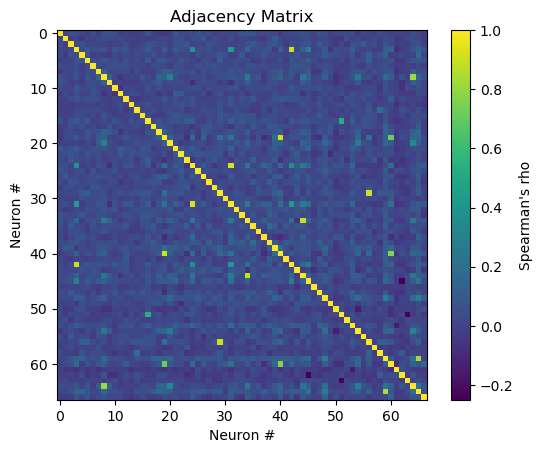

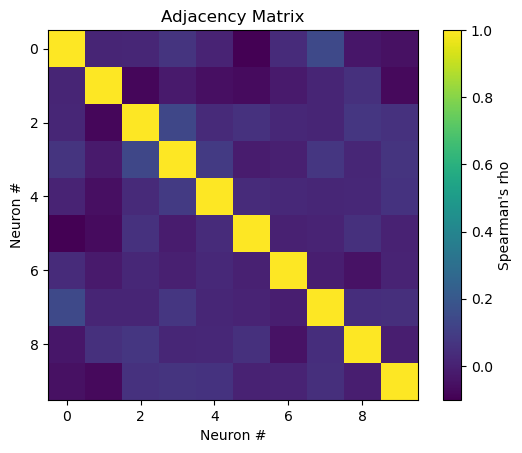

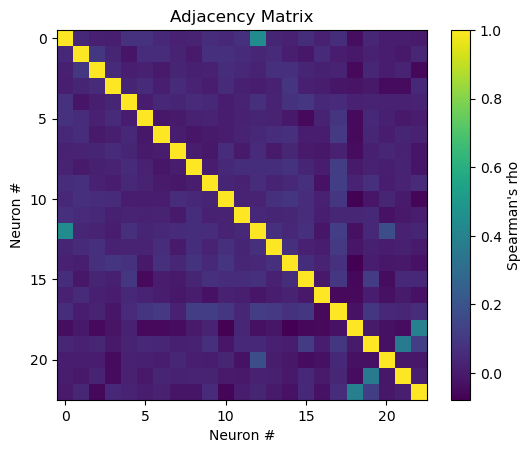

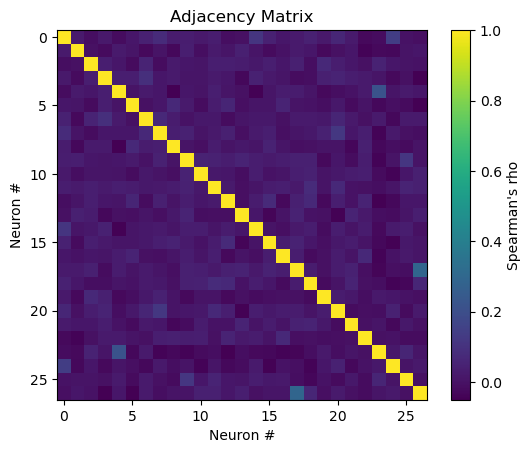

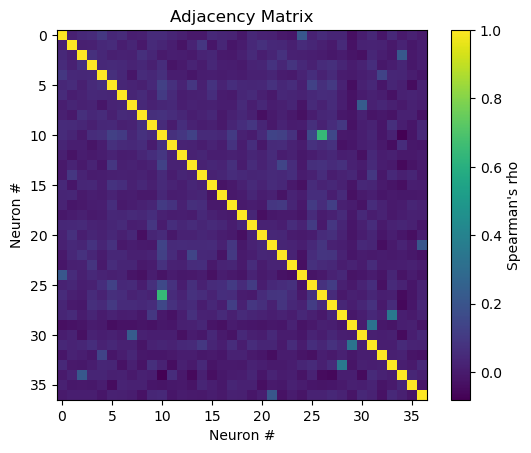

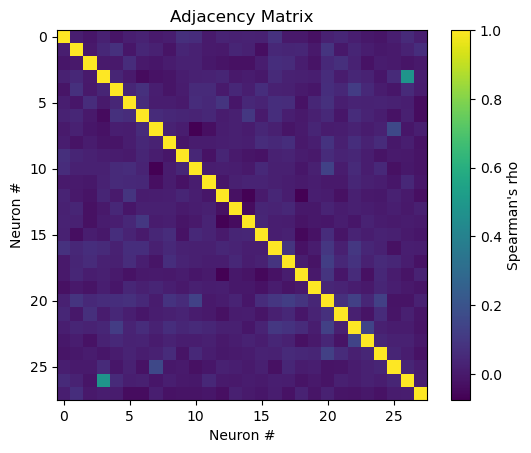

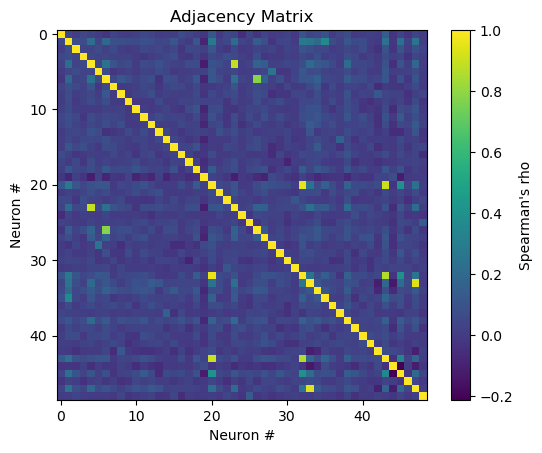

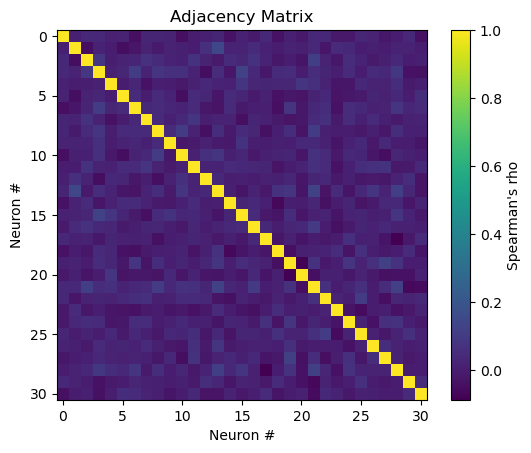

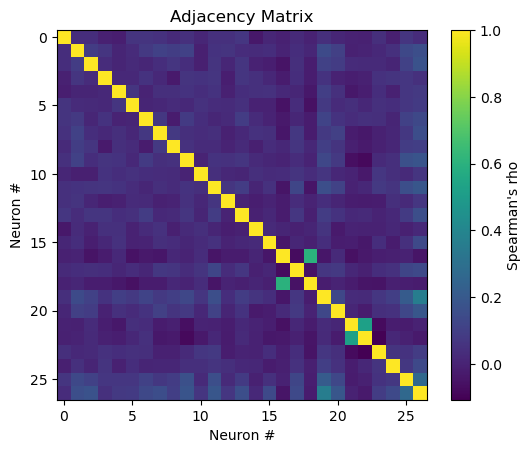

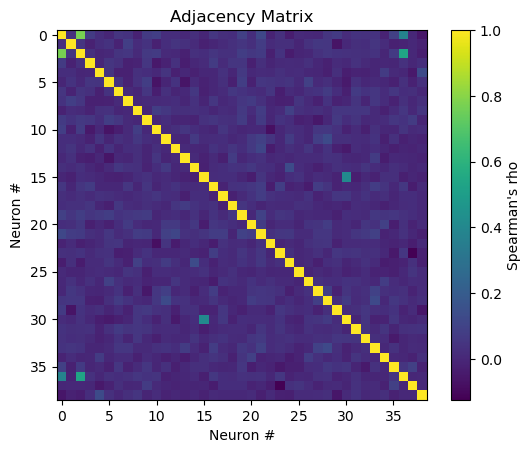

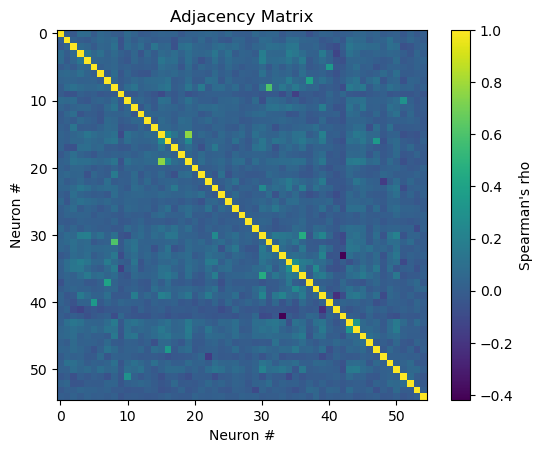

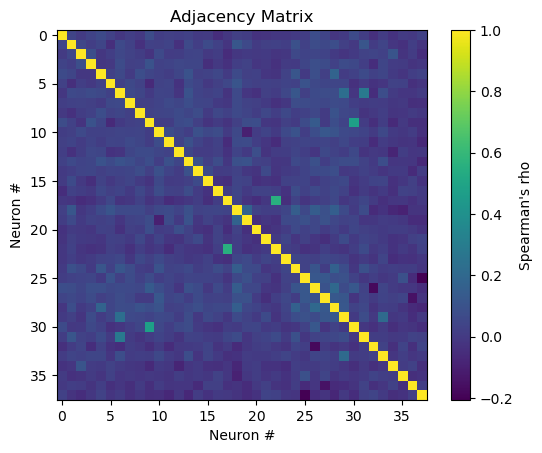

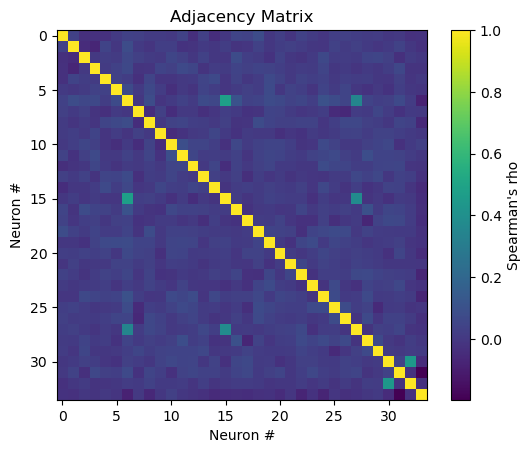

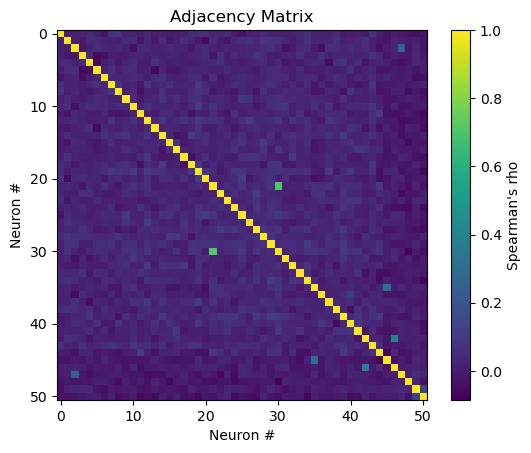

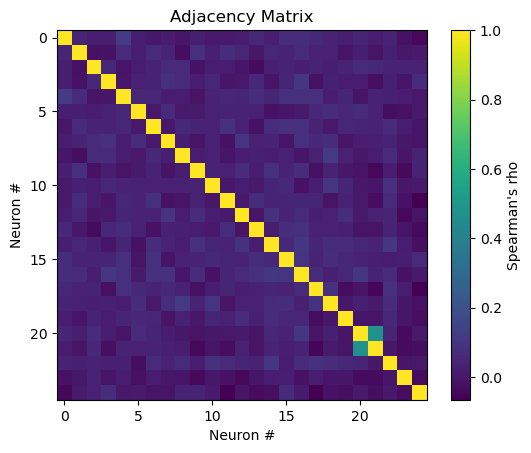

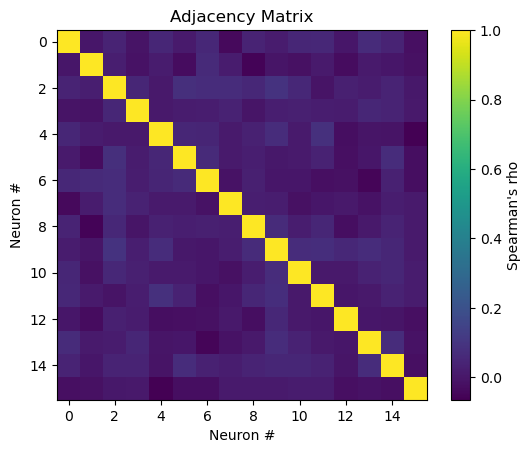

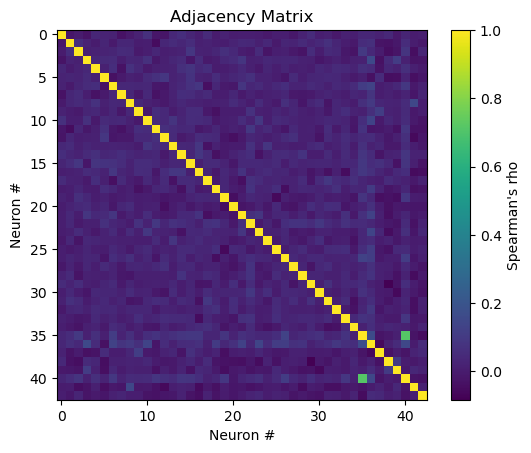

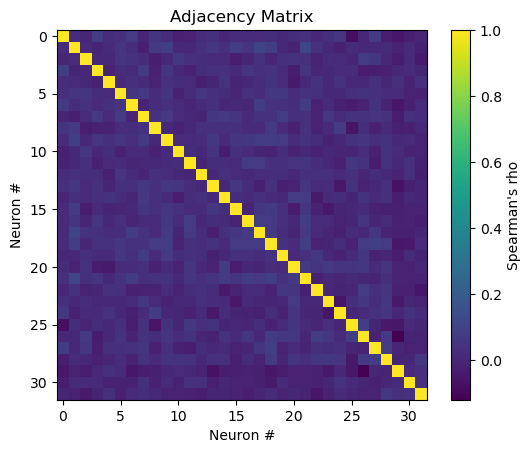

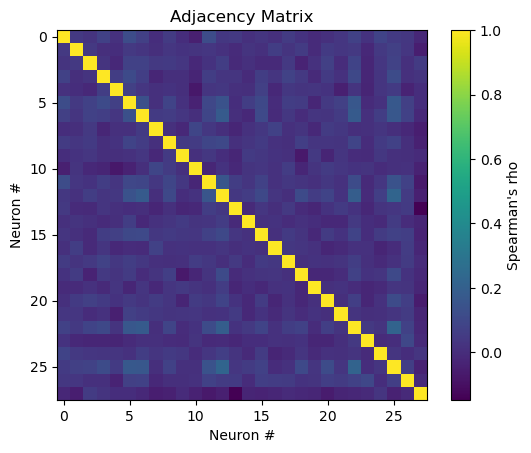

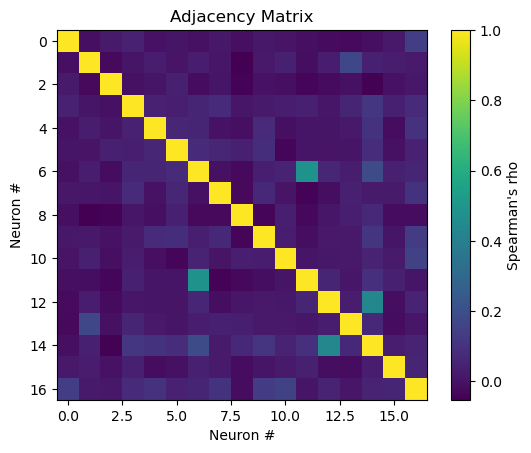

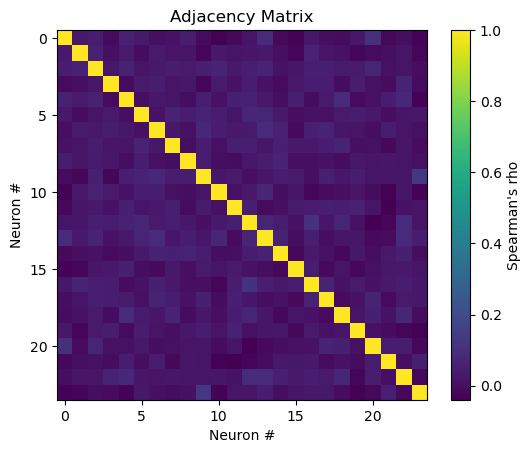

In [126]:
# Each square represents a "cell pair"
for i in range(len(traces)):
    fig2 = plt.figure()
    plt.imshow(corrs[i])
    plt.colorbar(label="Spearman's rho")
    plt.title("Adjacency Matrix")
    # Fix axis so that they don't show floats and start at 1 rather than 0
    plt.xlabel('Neuron #')
    plt.ylabel('Neuron #')

Average the spearman's rho values for the cell pairs. We use the matrix's lower diagonal

In [127]:
lower_triangle = {}
mean_corr = {}
for i in range(len(traces)):
    lower_triangle[i] = np.tril(corrs[i])
    mean_corr[i] = np.mean(lower_triangle[i]) 

Synchrony value for each slice

In [128]:
# Datapoints (one for each video)
mean_corr

{0: 0.1005922651482413,
 1: 0.07691250589171593,
 2: 0.06340100786359242,
 3: 0.06600554953551016,
 4: 0.042167689002568495,
 5: 0.05393594163225262,
 6: 0.03858773671386781,
 7: 0.04705283172627361,
 8: 0.06269399483258858,
 9: 0.028483137635170797,
 10: 0.06564234800256333,
 11: 0.03793332950874184,
 12: 0.04463454765022619,
 13: 0.03302949978350054,
 14: 0.10696494634676343,
 15: 0.05757117270857411,
 16: 0.04416172164057562,
 17: 0.038755777604075295,
 18: 0.045378633102166846,
 19: 0.03929645294193656,
 20: 0.0393432321756069,
 21: 0.054573189411003475,
 22: 0.03614883253912909,
 23: 0.033534014103626775,
 24: 0.03676134664976687,
 25: 0.03804513521537978,
 26: 0.030832139938433357,
 27: 0.05415065131712394,
 28: 0.07120523561526561,
 29: 0.034215532518004056,
 30: 0.03993456939691356,
 31: 0.0495703342175483,
 32: 0.07402058889883094,
 33: 0.052454683955412876}

Calculating mean_corr for each group

In [129]:
mean_corr_vta_control = []
mean_corr_vta_injected = []
mean_corr_snc_control = []
mean_corr_snc_injected = []

for i in range(len(vta_control)):
    mean_corr_vta_control.append((mean_corr[vta_control[i]]))

for i in range(len(vta_injected)):
    mean_corr_vta_injected.append((mean_corr[vta_injected[i]]))

for i in range(len(snc_control)):
    mean_corr_snc_control.append((mean_corr[snc_control[i]]))

for i in range(len(snc_injected)):
    mean_corr_snc_injected.append((mean_corr[snc_injected[i]]))

In [130]:
mean_corr_vta_control

[0.04705283172627361,
 0.028483137635170797,
 0.03793332950874184,
 0.04463454765022619]

In [131]:
mean_corr_vta_injected

[0.1005922651482413,
 0.045378633102166846,
 0.0393432321756069,
 0.054573189411003475,
 0.03614883253912909,
 0.05415065131712394]

In [132]:
mean_corr_snc_control

[0.07691250589171593,
 0.03858773671386781,
 0.06564234800256333,
 0.03929645294193656,
 0.03676134664976687,
 0.03804513521537978,
 0.03993456939691356,
 0.052454683955412876]

In [133]:
mean_corr_snc_injected

[0.06340100786359242,
 0.06600554953551016,
 0.042167689002568495,
 0.05393594163225262,
 0.06269399483258858,
 0.03302949978350054,
 0.10696494634676343,
 0.05757117270857411,
 0.04416172164057562,
 0.038755777604075295,
 0.033534014103626775,
 0.030832139938433357,
 0.07120523561526561,
 0.034215532518004056,
 0.0495703342175483,
 0.07402058889883094]

In [134]:
mean_corr_snc_injected = pd.DataFrame(mean_corr_snc_injected).dropna()

In [135]:
mean_corr_snc_injected = mean_corr_snc_injected[0].tolist()

In [136]:
mean_corr_snc_injected

[0.06340100786359242,
 0.06600554953551016,
 0.042167689002568495,
 0.05393594163225262,
 0.06269399483258858,
 0.03302949978350054,
 0.10696494634676343,
 0.05757117270857411,
 0.04416172164057562,
 0.038755777604075295,
 0.033534014103626775,
 0.030832139938433357,
 0.07120523561526561,
 0.034215532518004056,
 0.0495703342175483,
 0.07402058889883094]

t-test between different groups (SNc, VTA, subgroups: control & injected)

In [137]:
t_test_vta = stats.ttest_ind(mean_corr_vta_control, mean_corr_vta_injected)
t_test_snc = stats.ttest_ind(mean_corr_snc_control, mean_corr_snc_injected)

In [138]:
t_test_vta

Ttest_indResult(statistic=-1.2445993910866942, pvalue=0.2485032805984155)

In [139]:
t_test_snc

Ttest_indResult(statistic=-0.6688383783620961, pvalue=0.5105565874970112)

In [141]:
len(mean_corr)

34

In [143]:
count = 0
for i in range(len(mean_corr)):
    if mean_corr[i] <= 0.05:
        count = count + 1
print(count)        

20
